In [78]:
import torch
import wandb
import torch.optim as optim
from utils.wandb import wandb_init
from train_rq_vae import train
from omegaconf import OmegaConf
from plotting.plot import plot_results_panels
from data.loader import load_movie_lens
from modules.rq_vae import RQ_VAE
from utils.model_id_generation import generate_model_id

In [79]:
cfg = OmegaConf.load('config/config_ml100k.yaml') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb_init(cfg)

data = load_movie_lens(category='100k', 
                       dimension="user", 
                       train=True, 
                       raw=True)

model = RQ_VAE(
        input_dim = data.shape[1],
        latent_dim = cfg.model.latent_dimension,
        hidden_dims = cfg.model.hidden_dimensions,
        codebook_size = cfg.model.codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = cfg.model.num_codebook_layers,
        commitment_weight = cfg.model.commitment_weight,
)
model.to(device)

wandb.watch(model)

optimizer = optim.AdamW(model.parameters(), lr=cfg.train.learning_rate, weight_decay=cfg.train.weight_decay)

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

In [80]:
losses = train(model, data, optimizer, cfg.train.num_epochs, device, cfg)

if cfg.general.save_model:
    model_id = generate_model_id(cfg)
    print(f"Model ID: {model_id}")
    torch.save(model.state_dict(), f"models/{model_id}.pth")
    
#model.load_state_dict(torch.load("models/amazon-beauty-bs256-normF-hd768_512_256-ld256-cb3x256-cw0.25-lr0.001-wd0.0001-ep200.pth"))
wandb.finish()

Training Loop: 100%|██████████| 1024/1024 [01:58<00:00,  8.66it/s, Epoch=1023, Loss=80.4, Reconstruction Loss=76.8, RQ-VAE Loss=3.63, Prob Unique IDs=0.986]  


Model ID: movielens-bs128-user-normF-hd768_256-ld256-cb2x256-cw0.1-lr0.001-wd0.0001-ep1024


Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
Loss,█▇▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Prob Unique IDs,▁▁▁▁▂▃▄▄▅▅▆▇▇▇▇▇▇▇██████████████████████
RQ-VAE Loss,▁▁▁▂▂▂▂▂▂▂▂▂▃▆▆▄▄▄▄▅▅▆▆▆▆▆▆▇▆▇▇██▇▇▇████
Reconstruction Loss,█▇▇▇▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1023
Loss,80.39796
Prob Unique IDs,0.98633
RQ-VAE Loss,3.62582
Reconstruction Loss,76.77214


In [81]:
model.get_semantic_ids(data.to(device)).sem_ids

tensor([[243,  52],
        [194,   6],
        [ 18,  94],
        ...,
        [203,  84],
        [181, 173],
        [214, 127]], device='cuda:0')

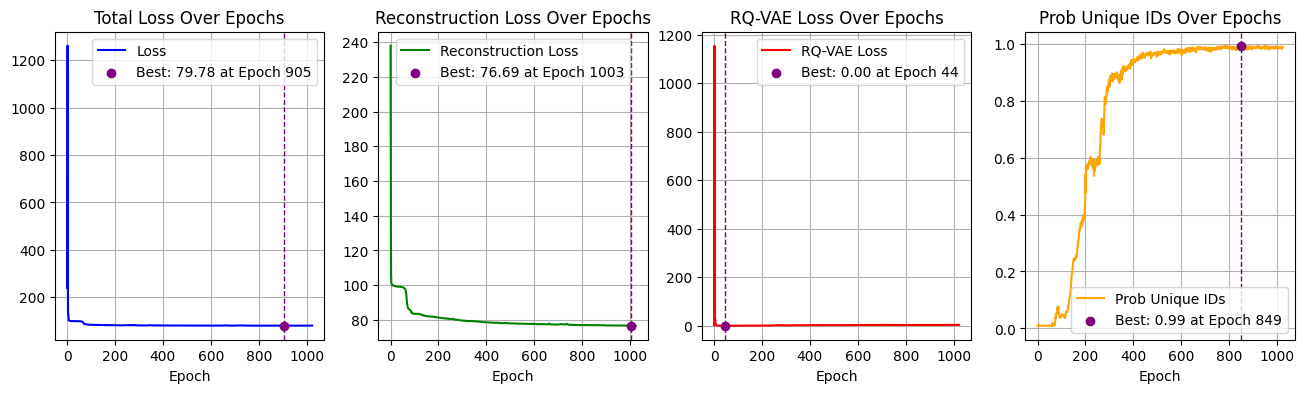

In [82]:
# Plot configuration
plot_configs = [
    ('Loss', 'Total Loss Over Epochs', 'blue', 'low'),
    ('Reconstruction Loss', 'Reconstruction Loss Over Epochs', 'green', 'low'),
    ("RQ-VAE Loss", 'RQ-VAE Loss Over Epochs', 'red', 'low'),
    ('Prob Unique IDs', 'Prob Unique IDs Over Epochs', 'orange', 'high'),
]

model_id = generate_model_id(cfg)
fig = plot_results_panels(losses, plot_configs)
fig.savefig(f"outputs/plots/{model_id}.png", dpi=600, bbox_inches='tight')